## Install dependencies

In [ ]:
!pip install torchvision==0.7.0 --quiet

     |████████████████████████████████| 5.9 MB 14.5 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0 which is incompatible.


In [ ]:
!pip install tensorboard==2.2.1 --quiet 

     |████████████████████████████████| 3.0 MB 13.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires tensorboard~=2.6, but you have tensorboard 2.2.1 which is incompatible.


In [ ]:
!pip install pytorch-lightning==1.1.0 --quiet

     |████████████████████████████████| 665 kB 13.0 MB/s 
     |████████████████████████████████| 596 kB 50.1 MB/s 
     |████████████████████████████████| 829 kB 57.1 MB/s 
     |████████████████████████████████| 132 kB 67.8 MB/s 


In [ ]:
!pip install torch==1.7.0 --quiet

     |████████████████████████████████| 776.7 MB 4.6 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0 requires torch==1.6.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.


In [ ]:
!pip install torchtext==0.8.0 --quiet

     |████████████████████████████████| 6.9 MB 14.4 MB/s 


## Clone project repo

contents 
- pretrained patches checkpoints
- training results for pretrained patches

In [ ]:
!git clone https://github.com/malcolmsfraser/Adversarial-Patch-Attacks.git

Cloning into 'Adversarial-Patch-Attacks'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [ ]:
%cd Adversarial-Patch-Attacks/

/content/Adversarial-Patch-Attacks


## Download pretained models

In [ ]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 643, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 643 (delta 43), reused 50 (delta 21), pack-reused 552
Receiving objects: 100% (643/643), 6.59 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [ ]:
%cd PyTorch_CIFAR10/

/content/Adversarial-Patch-Attacks/PyTorch_CIFAR10


In [ ]:
!python train.py --download_weights 1

100% 979M/979M [01:26<00:00, 11.3MMiB/s]
Download successful. Unzipping file...
Unzip file successful!


In [ ]:
import torch
import torchvision
import tensorboard


print(f"torch version: {torch.__version__}\ntorchvsion version: {torchvision.__version__}\ntensorboard version: {tensorboard.__version__}")

torch version: 1.7.0
torchvsion version: 0.7.0
tensorboard version: 2.2.1


## Setup Env for Patch Training/Attack

In [ ]:
!pwd #should still be inside the PyTorch_CIFAR10

/content/Adversarial-Patch-Attacks/PyTorch_CIFAR10


In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"
if not os.path.exists(CHECKPOINT_PATH):
  os.makedirs(CHECKPOINT_PATH)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [ ]:
from cifar10_models.resnet import resnet34

# Load pretrained resnet34 model
my_model = resnet34(pretrained=True)
my_model.to(device)

# No gradients needed for the network
my_model.eval()
for p in my_model.parameters():
    p.requires_grad = False

## Prepare the CIFAR10 Dataset

In [ ]:
# Mean and Std from CIFAR10
NORM_MEAN = np.array([0.49139968, 0.48215827, 0.44653124])
NORM_STD = np.array([0.24703233, 0.24348505, 0.26158768])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True,
                                        download=True, transform=plain_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False,
                                       download=True, transform=plain_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

label_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

0it [00:00, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


## Evaluate the baseline model

### Helper functions

In [ ]:
def eval_model(my_model, dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = my_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5


def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

### Baseline ResNet34 results

Validating...:   0%|          | 0/1563 [00:00<?, ?it/s]

Top-1 error: 0.10%
Top-5 error: 0.01%


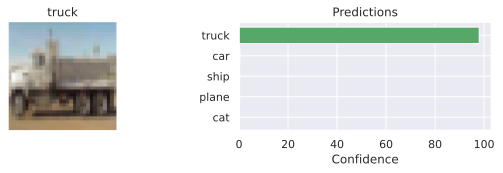

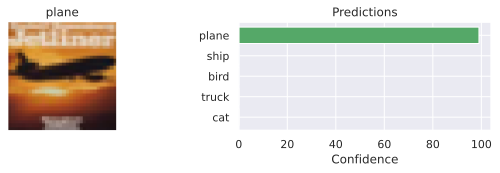

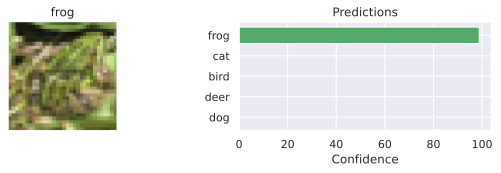

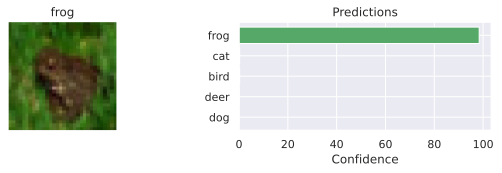

In [ ]:
# Evaluate model
_ = eval_model(my_model, trainloader)

# Show model predictions
exmp_batch, label_batch = next(iter(trainloader))

with torch.no_grad():
    preds = my_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Setup for patch training/attack

In [ ]:
def place_patch(img, patch):
  """Applies a random offset to the patch placement to improve robustness"""
  for i in range(img.shape[0]):
      h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
      w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
      img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
  return img


TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
  """Normalized the patch values to fall within the range of values in the original CIFAR10 data"""
  # Map patch values from [-infty,infty] to CIFAR10 min and max
  patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
  return patch


def eval_patch(model, patch, val_loader, target_class):
  """
  Evaluates how well the patch is able to "fool" the model into predicting the patch class
  acc: proportion of the time the patch class is the top prediction 
  top5: proportion of the time the patch class in in the top 5 predictions
  """

  model.eval()
  tp, tp_5, counter = 0., 0., 0.
  with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4): 
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
  acc = tp/counter
  top5 = tp_5/counter
  return acc, top5


def patch_attack(model, target_class, patch_size=4, num_epochs=5):
    """
    Implements the a patch attack, training the patch as a parameter to be a predictor of our target class
    Evaluates the trained patch's effectiveness on a holdout dataset
    Returns the trained patch as well as the results of the patch attack
    """

    train_set, val_set = torch.utils.data.random_split(trainset, [45000, 5000])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
    
    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}


def get_patches(my_model, class_names, patch_sizes, evaluate=False):
    """
    Implements the patch attack for a given set of class names and patch sizes
    Returns all the patches and results as a dictionary
    """
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                print('Training patch')
                patch, val_results = patch_attack(my_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                if not os.path.exists(os.path.dirname(file_name)):
                    os.makedirs(os.path.dirname(file_name))
                torch.save(patch, file_name)
            else:
                print("Patch found")
                patch = torch.load(file_name)
            if evaluate:
                results = eval_patch(my_model, patch, trainloader, target_class=c)
            else:
              results = ['Patch not evaluated']
            
            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }
        
    return result_dict


def save_results(patch_dict):
    """Used to write all the patches and attack results to disk"""
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)


def show_patches(patch_dict):
    """Visualized the trained patches"""
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]['patch']
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

    
def perform_patch_attack(my_model, patch):
  """Applies the attack to our model"""
  patch_batch = exmp_batch.clone()
  patchy_batch = place_patch(patch_batch, patch)
  with torch.no_grad():
      patch_preds = my_model(patch_batch.to(device))
  for i in range(0,len(patch_batch),5):
      show_prediction(patchy_batch[i], label_batch[i], patch_preds[i])


def eval_patch_model(my_model, dataset_loader, patch, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = place_patch(imgs, patch)
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = my_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1-acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1-top5)):4.2f}%")
    return acc, top5

## Train/Get Patches

In [ ]:
# Patches classes to train
class_names = ['plane', 'car', 'bird', 'cat']

# Patch sizes to train
patch_sizes = [2, 4, 8]

In [ ]:
# Setting evaluation saves time when loading the pretrained patches
# Results for the default patches can be found in the saved_models folder
patch_dict = get_patches(my_model, class_names, patch_sizes, evaluate=False)

## Uncomment this section if evaluating new patches
# save_results(patch_dict) 

Patch found
Patch found
Patch found
Patch found
Patch found
Patch found
Patch found
Patch found
Patch found
Patch found
Patch found
Patch found


## Patch Attack!
- Visualize patches and patch results on training data
- Perform patch attack on the baseline (ResNet34) model
- Perform patch transfer attack on ResNet18
- Perform patch transfer attack on Vgg16 

### Visualize patches and patch results on training data

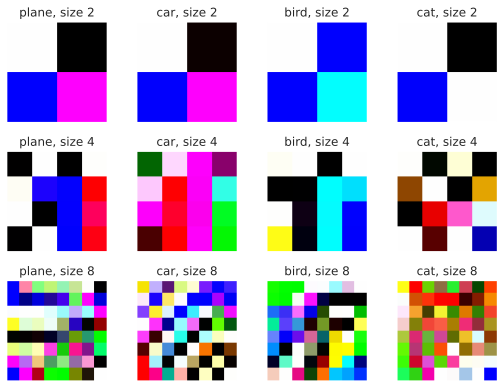

In [ ]:
show_patches(patch_dict)

In [ ]:
results_path = os.path.join(CHECKPOINT_PATH, 'patch_results.json')
with open(results_path,"r") as f:
  loaded_patch_dict = json.load(f)

print("Patch metrics\nDoes the patch fool the model into predicting the patch's target class?")
for cl in class_names:
    print('\n')
    for size in patch_sizes:
        print(f"{cl:5} size = {size} :: Acc {loaded_patch_dict[cl][str(size)][0] :.4f}, Top-5 {loaded_patch_dict[cl][str(size)][1] :.4f}")

Patch metrics
Does the patch fool the model into predicting the patch's target class?


plane size = 2 :: Acc 0.0764, Top-5 0.5966
plane size = 4 :: Acc 0.2356, Top-5 0.7785
plane size = 8 :: Acc 0.6880, Top-5 0.9643


car   size = 2 :: Acc 0.0057, Top-5 0.1909
car   size = 4 :: Acc 0.0501, Top-5 0.4675
car   size = 8 :: Acc 0.8352, Top-5 0.9882


bird  size = 2 :: Acc 0.0674, Top-5 0.7658
bird  size = 4 :: Acc 0.2998, Top-5 0.9232
bird  size = 8 :: Acc 0.8521, Top-5 0.9995


cat   size = 2 :: Acc 0.0531, Top-5 0.8970
cat   size = 4 :: Acc 0.4057, Top-5 0.9810
cat   size = 8 :: Acc 0.9320, Top-5 1.0000


### Perform patch attack

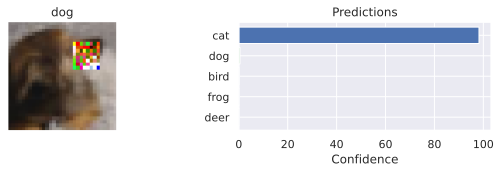

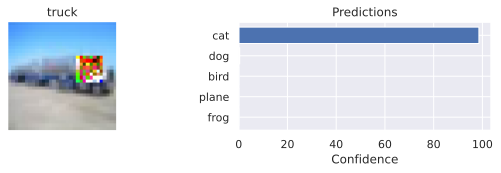

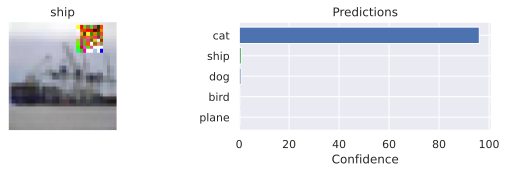

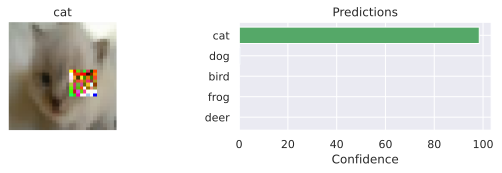

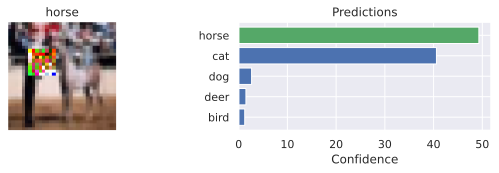

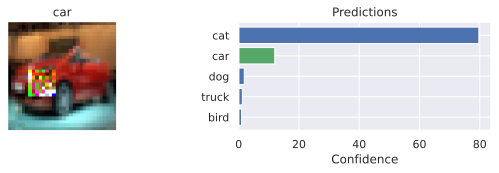

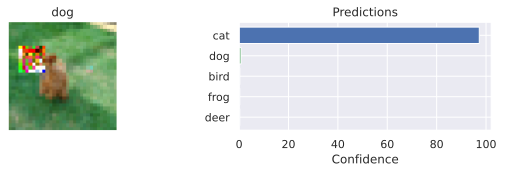

In [ ]:
cl = 'cat' # patch class to visualize
s = 8 # patch size to visualize

perform_patch_attack(my_model, patch_dict[cl][s]['patch'])

In [ ]:
# Change cl to any of the other trained patches (plane, car, bird, or cat)
cl = 'car'

print('No patch')
_ = eval_model(my_model,testloader)

for psize in patch_sizes:
  print(f"\nPatch size {psize}")
  _ = eval_patch_model(my_model, testloader, patch_dict[cl][psize]['patch'])

No patch


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 6.67%
Top-5 error: 0.25%

Patch size 2


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 12.04%
Top-5 error: 0.70%

Patch size 4


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 19.48%
Top-5 error: 2.35%

Patch size 8


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 58.01%
Top-5 error: 10.98%


### Transfer Attack - Resnet18

In [ ]:
from cifar10_models.resnet import resnet18
from cifar10_models.vgg import vgg16_bn

# Load pretrained models
res18_model = resnet18(pretrained=True)
vgg16_model = vgg16_bn(pretrained=True)

In [ ]:
# set patch class
cl = 'car'

res18_model.to(device)
print("Evaluating resnet18 error\n")
print(f'Patch class: {cl}')

# No gradients needed for the network
res18_model.eval()
for p in res18_model.parameters():
    p.requires_grad = False
print("No patch")
_ = eval_model(res18_model,testloader)
print('\n')

for psize in [2,4,8]:
  print(f"\nPatch size {psize}")
  _ = eval_patch_model(res18_model, testloader, patch_dict[cl][psize]['patch'])
  print('\n')

Evaluating resnet18 error

Patch class: car
No patch


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 6.93%
Top-5 error: 0.26%



Patch size 2


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 12.05%
Top-5 error: 0.57%



Patch size 4


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 23.22%
Top-5 error: 2.21%



Patch size 8


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 39.40%
Top-5 error: 9.48%




In [ ]:
# set patch class
cl = 'car'

print('Evaluating patch accuracy on ResNet18\n')
print(f'Patch class: {cl}')

for psize in [2,4,8]:
  print(f"\nPatch size {psize}")
  top1, top5 = eval_patch(res18_model, patch_dict[cl][psize]['patch'], testloader, get_label_index(cl))
  print(f"Top1 acc: {100*top1.item():.2f}%, Top5 acc: {100*top5.item():.2f}%")

Evaluating patch accuracy on ResNet18

Patch class: car

Patch size 2


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 0.89%, Top5 acc: 24.11%

Patch size 4


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 10.04%, Top5 acc: 66.90%

Patch size 8


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 59.69%, Top5 acc: 92.75%


### Transfer Attack - Vgg16

In [ ]:
# Set patch class
cl = 'car'

vgg16_model.to(device)
print('Evaluating Vgg16 error \n')
print(f"Patch class: {cl}\n")

# No gradients needed for the network
vgg16_model.eval()
for p in vgg16_model.parameters():
    p.requires_grad = False
print("No patch")
_ = eval_model(vgg16_model,testloader)
print('\n')

for psize in [2,4,8]:
  print(f"\nPatch size {psize}")
  _ = eval_patch_model(vgg16_model, testloader, patch_dict[cl][psize]['patch'])
  print('\n')

Evaluating Vgg16 error 

Patch class: car

No patch


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 6.00%
Top-5 error: 0.36%



Patch size 2


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 11.79%
Top-5 error: 1.00%



Patch size 4


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 22.36%
Top-5 error: 4.31%



Patch size 8


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 37.54%
Top-5 error: 7.29%




In [ ]:
#set patch class
cl = 'car'

print('Evaluating patch accuracy on Vgg16\n')
print(f"Patch class: {cl}")

for psize in [2,4,8]:
  print(f"\nPatch size {psize}")
  top1, top5 = eval_patch(vgg16_model, patch_dict[cl][psize]['patch'], testloader, get_label_index(cl))
  print(f"Top1 acc: {100*top1.item():.2f}%, Top5 acc: {100*top5.item():.2f}%")

Evaluating patch accuracy on Vgg16

Patch class: car

Patch size 2


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 0.88%, Top5 acc: 31.89%

Patch size 4


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 5.70%, Top5 acc: 50.08%

Patch size 8


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 10.98%, Top5 acc: 35.73%
